# Vertical Coord Transforms

I need to figure out how to take a ds_gridded with dimensions `density`, `lon`, `lat` and transform it to have dimensions `av isopycnal depth`, `lon`, `lat`. I've done this before for data with dimensions `density`, `N_PROF`. I don't think this will be very difficult?? Hoping I just have to 
1. flatten the dataset into having dimensions `density`, `N_PROF`
2. perform calculations with established functions
3. reshape the dataset back into the original dimensions of `density`, `lon`, `lat`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from xgcm import Grid

In [3]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [4]:
section = ds_x.where((ds_x.LATITUDE < -45) & (ds_x.LATITUDE > -50),drop=True).where((ds_x.LONGITUDE < 30) & (ds_x.LONGITUDE > 25),drop=True).sortby('LATITUDE')

In [42]:
section = section.sortby('N_PROF')

In [43]:
#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_x = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [44]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [366]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES'], ['PRES']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    #ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [131]:
section_rho = get_ds_rho(section_x, section_x.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','PRES_INTERPOLATED'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed merge


In [194]:
def func_var_int_pmean(ds, var, Pmean_smooth):
    Pmean_grid = np.linspace(0, 2000, 1001)
    
    ds_nonan = ds[var].where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    # Extract the latitude value for the current profile
    latitude_val = ds.LATITUDE.values
    time_val = ds.TIME.values
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values, extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)

    else:
        ds_on_Pmean = np.nan * Pmean_grid
    
    # Return a DataArray with the Pmean and LATITUDE coordinates
    return xr.DataArray(ds_on_Pmean.reshape((-1, 1)),
                        dims=['Pmean', 'N_PROF'],
                        coords={'Pmean': Pmean_grid, 'N_PROF': [ds.N_PROF.values], 'LATITUDE': ('N_PROF', [latitude_val]), 'TIME': ('N_PROF', [time_val])}).rename(var)

In [195]:
# List to store profiles that cause the error
problem_profiles = []

# Initial setup (placeholders for your actual data)
# section_rho = xr.Dataset(...)
Pmean_smooth = section_rho.PRES.mean('N_PROF').rolling(rho_grid=50, center=True).mean()

# Interpolate to iso
N_PROF_ind = 0
CT_on_Pmean = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'CT', Pmean_smooth)

for N_PROF_ind in range(1, len(section_rho.N_PROF)):
    if np.mod(N_PROF_ind, 50) == 0:
        print(f"Processing profile: {N_PROF_ind}")

    try:
        new_data = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'CT', Pmean_smooth)
        # Ensure new_data is a DataArray before concatenating
        if isinstance(new_data, xr.DataArray):
            CT_on_Pmean = xr.concat([CT_on_Pmean, new_data], dim='N_PROF')
        else:
            # This case should ideally not be reached with the corrected func_var_int_pmean
            print(f"Warning: Unexpected data type returned for profile {N_PROF_ind}.")
            problem_profiles.append(N_PROF_ind)

    except ValueError as e:
        if "`x` must be strictly increasing sequence" in str(e):
            print(f"Skipping profile {N_PROF_ind} due to interpolation error (x not strictly increasing).")
            problem_profiles.append(N_PROF_ind)
            # If func_var_int_pmean returns NaNs correctly, we don't need to explicitly add a NaN DataArray here.
            # The corrected function handles this.
        else:
            print(f"An unexpected ValueError occurred for profile {N_PROF_ind}: {e}")
            problem_profiles.append(N_PROF_ind)
            # Re-raise other unexpected ValueErrors if you want to stop execution
            # raise

# Print all problem profiles at the end
print("\n--- Summary ---")
print("Profiles that encountered interpolation errors or other issues:")
if problem_profiles:
    print(problem_profiles)
else:
    print("No problematic profiles found.")

Processing profile: 50
Processing profile: 100
Processing profile: 150
Skipping profile 199 due to interpolation error (x not strictly increasing).
Processing profile: 200
Skipping profile 200 due to interpolation error (x not strictly increasing).
Skipping profile 217 due to interpolation error (x not strictly increasing).
Processing profile: 250
Skipping profile 251 due to interpolation error (x not strictly increasing).
Skipping profile 259 due to interpolation error (x not strictly increasing).
Processing profile: 300
Skipping profile 300 due to interpolation error (x not strictly increasing).

--- Summary ---
Profiles that encountered interpolation errors or other issues:
[199, 200, 217, 251, 259, 300]


In [223]:
# List to store profiles that cause the error
problem_profiles = []

# Initial setup (placeholders for your actual data)
# section_rho = xr.Dataset(...)
Pmean_smooth = section_rho.PRES.mean('N_PROF').rolling(rho_grid=50, center=True).mean()

# Interpolate to iso
N_PROF_ind = 0
SIG0_on_Pmean = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'SIG0', Pmean_smooth)

for N_PROF_ind in range(1, len(section_rho.N_PROF)):
    if np.mod(N_PROF_ind, 50) == 0:
        print(f"Processing profile: {N_PROF_ind}")

    try:
        new_data = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'SIG0', Pmean_smooth)
        # Ensure new_data is a DataArray before concatenating
        if isinstance(new_data, xr.DataArray):
            SIG0_on_Pmean = xr.concat([SIG0_on_Pmean, new_data], dim='N_PROF')
        else:
            # This case should ideally not be reached with the corrected func_var_int_pmean
            print(f"Warning: Unexpected data type returned for profile {N_PROF_ind}.")
            problem_profiles.append(N_PROF_ind)

    except ValueError as e:
        if "`x` must be strictly increasing sequence" in str(e):
            print(f"Skipping profile {N_PROF_ind} due to interpolation error (x not strictly increasing).")
            problem_profiles.append(N_PROF_ind)
            # If func_var_int_pmean returns NaNs correctly, we don't need to explicitly add a NaN DataArray here.
            # The corrected function handles this.
        else:
            print(f"An unexpected ValueError occurred for profile {N_PROF_ind}: {e}")
            problem_profiles.append(N_PROF_ind)
            # Re-raise other unexpected ValueErrors if you want to stop execution
            # raise

# Print all problem profiles at the end
print("\n--- Summary ---")
print("Profiles that encountered interpolation errors or other issues:")
if problem_profiles:
    print(problem_profiles)
else:
    print("No problematic profiles found.")

Processing profile: 50
Processing profile: 100
Processing profile: 150
Processing profile: 200
Processing profile: 250
Skipping profile 281 due to interpolation error (x not strictly increasing).
Skipping profile 284 due to interpolation error (x not strictly increasing).
Skipping profile 287 due to interpolation error (x not strictly increasing).
Skipping profile 288 due to interpolation error (x not strictly increasing).
Skipping profile 289 due to interpolation error (x not strictly increasing).
Skipping profile 290 due to interpolation error (x not strictly increasing).
Processing profile: 300

--- Summary ---
Profiles that encountered interpolation errors or other issues:
[281, 284, 287, 288, 289, 290]


In [232]:
CT_on_Pmean

<xarray.DataArray 'CT' (Pmean: 1001, N_PROF: 300)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Pmean     (Pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * N_PROF    (N_PROF) int64 2kB 783949 783952 783955 ... 785051 785052 785053
    LATITUDE  (N_PROF) float64 2kB -45.25 -45.89 -45.16 ... -48.08 -47.77 -48.2
    TIME      (N_PROF) datetime64[ns] 2kB 2014-05-31T09:52:57 ... 2025-03-09T...
    profile   (N_PROF) int64 2kB 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299

In [199]:
x = 'TIME'
section_x = section_x.sortby(x)
section_rho = section_rho.sortby(x)
CT_on_Pmean = CT_on_Pmean.sortby(x)

In [205]:
section_x = section_x.assign_coords(profile=("N_PROF", np.arange(len(section_x.N_PROF))))
section_rho = section_rho.assign_coords(profile=("N_PROF", np.arange(len(section_rho.N_PROF))))
CT_on_Pmean = CT_on_Pmean.assign_coords(profile=("N_PROF", np.arange(len(CT_on_Pmean.N_PROF))))

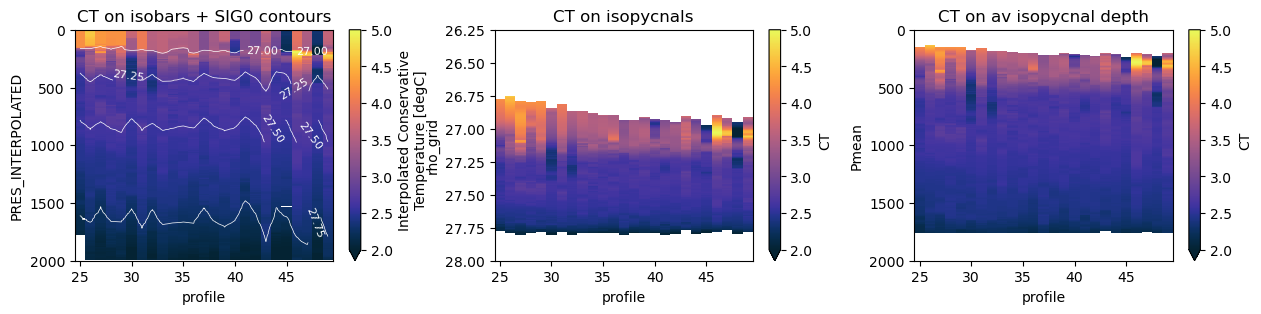

In [249]:
plt.figure(figsize=(15,3))
x = 'profile'
sel = slice(25,50)

# Extract data for contouring
X = section_x[x].isel(N_PROF=sel)
Y = section_x['PRES_INTERPOLATED']
Z = section_x.SIG0.isel(N_PROF=sel)

plt.subplot(131)
section_x.CT.isel(N_PROF=sel).sortby(x).plot(x=x, y='PRES_INTERPOLATED',cmap=cmo.thermal,vmin=2,vmax=5)
cs = plt.contour(X, Y, Z.transpose(), levels=np.arange(24, 28, 0.25), colors='white', linewidths=0.5)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.2f")
plt.gca().invert_yaxis()
plt.title('CT on isobars + SIG0 contours')

plt.subplot(132)
section_rho.CT.isel(N_PROF=sel).sortby(x).plot(x=x,y='rho_grid',cmap=cmo.thermal,vmin=2,vmax=5)
plt.ylim(28,26.25)
plt.title('CT on isopycnals')

plt.subplot(133)
CT_on_Pmean.isel(N_PROF=sel).sortby(x).plot(x=x,y='Pmean',cmap=cmo.thermal,vmin=2,vmax=5)
plt.gca().invert_yaxis()
plt.title('CT on av isopycnal depth')

plt.subplots_adjust(wspace=0.3)

Text(0.5, 1.0, '(CT on isobars) - (CT on av isopycnal depth)')

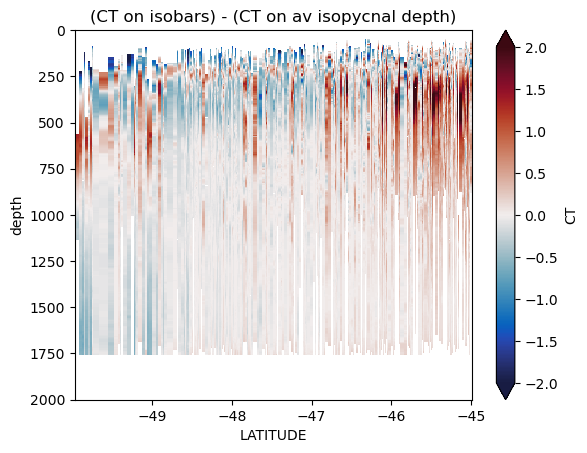

In [128]:
(section_x.CT.rename({'PRES_INTERPOLATED':'depth'}) - CT_on_Pmean.rename({'Pmean':'depth'})).plot(x='LATITUDE', vmin=-2, vmax=2, cmap=cmo.balance)
plt.gca().invert_yaxis()
plt.title('(CT on isobars) - (CT on av isopycnal depth)')

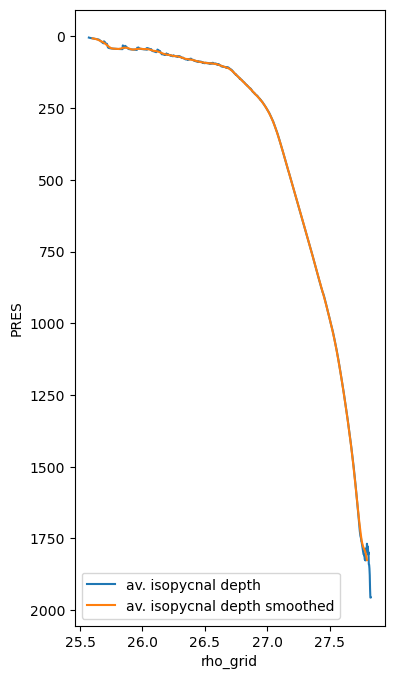

In [117]:
plt.figure(figsize=(4,8))

section_rho.PRES.mean('N_PROF').plot(label='av. isopycnal depth')
section_rho.PRES.mean('N_PROF').rolling(rho_grid=25, center=True).mean().plot(label='av. isopycnal depth smoothed')
plt.gca().invert_yaxis()
plt.legend()

Outstanding questions:
- Why does Pmean_smooth cut off more data points at the bottom than the top? _wondering if this is because it's cutting values off based on density, so cutting off the same number of density values is going to look like more in the deep ocean, because they change slower?_
- Everything else looks about correct, right?

# My attempt to rewrite/simplify

The above code is confusing. This is going to be my attempt at rewritting it while maintaining good functionality.

In [188]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [367]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    pmean_smooth = ds_rho.PRES.mean('N_PROF').rolling(rho_grid=roll, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[['rho_grid'], ['rho_grid']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    #ds_pmean = ds_pmean.assign_coords(LATITUDE  = ('N_PROF', ds_rho.LATITUDE.data))
    #ds_pmean = ds_pmean.assign_coords(LONGITUDE = ('N_PROF', ds_rho.LONGITUDE.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean

In [190]:
testing = get_ds_pmean(section_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'])

ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for CT
Completed CT
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SA
Completed SA
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SIG0
Completed SIG0
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SPICE
Completed SPICE
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for PRES
Completed PRES
Completed merge


Text(0.5, 1.0, 'my function')

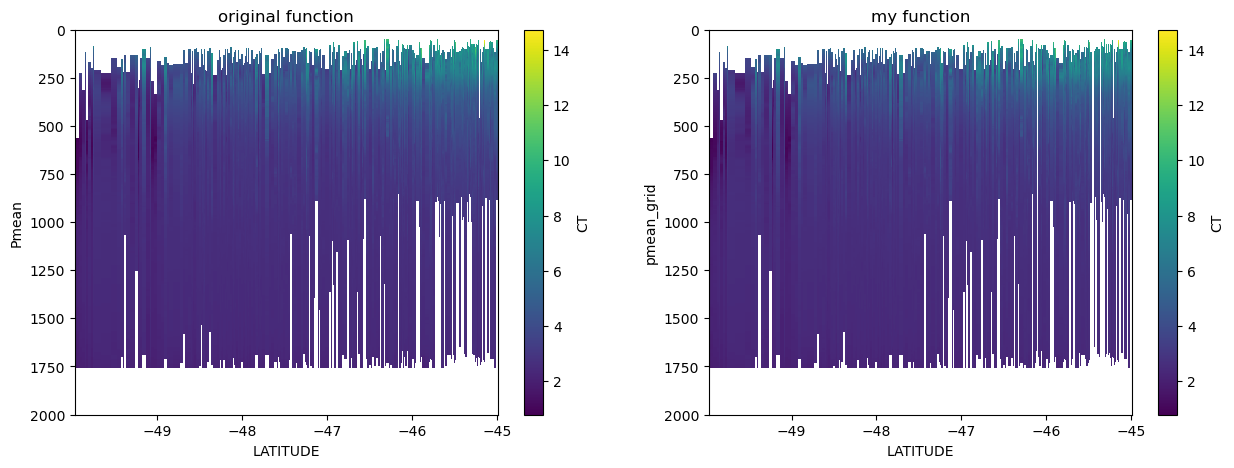

In [191]:
plt.figure(figsize=(15,5))

plt.subplot(121)
CT_on_Pmean.sortby('LATITUDE').plot(x='LATITUDE',y='Pmean')
plt.gca().invert_yaxis()
plt.title('original function')

plt.subplot(122)
testing.CT.sortby('LATITUDE').plot(x='LATITUDE',y='pmean_grid')
plt.gca().invert_yaxis()
plt.title('my function')

## Idealized Example

In [483]:
# Depth grid
pres = np.linspace(0, 2000, 1001)
n_profiles = 10

# Generate temperature profiles (exponential decay, profile-specific)
CT_profiles = []
for i in range(n_profiles):
    decay = 20 * np.exp(-pres / (500 + 25 * i))  # smooth decay
    CT_profiles.append(decay)

CT = xr.DataArray(
    data=np.array(CT_profiles),
    dims=["N_PROF", "PRES"],
    coords={"N_PROF": np.arange(n_profiles), "PRES": pres},
    name="CT"
)

# Generate salinity profiles (high at surface, decreasing with depth)
SA_profiles = []
for i in range(n_profiles):
    base = 36 - 1.5 * np.exp(-pres / (300 + 20 * i))  # smooth decay
    SA_profiles.append(base)

SA = xr.DataArray(
    data=np.array(SA_profiles),
    dims=["N_PROF", "PRES"],
    coords={"N_PROF": np.arange(n_profiles), "PRES": pres},
    name="SA"
)


In [484]:
# Calculate SIG0 using gsw.sigma0
SIG0 = gsw.sigma0(SA, CT)

# Wrap into an xarray DataArray
SIG0 = xr.DataArray(
    data=SIG0,
    dims=["N_PROF", "PRES"],
    coords={"N_PROF": SA.coords["N_PROF"], "PRES": SA.coords["PRES"]},
    name="SIG0"
)

Text(0.5, 1.0, 'SIG0 on isobars')

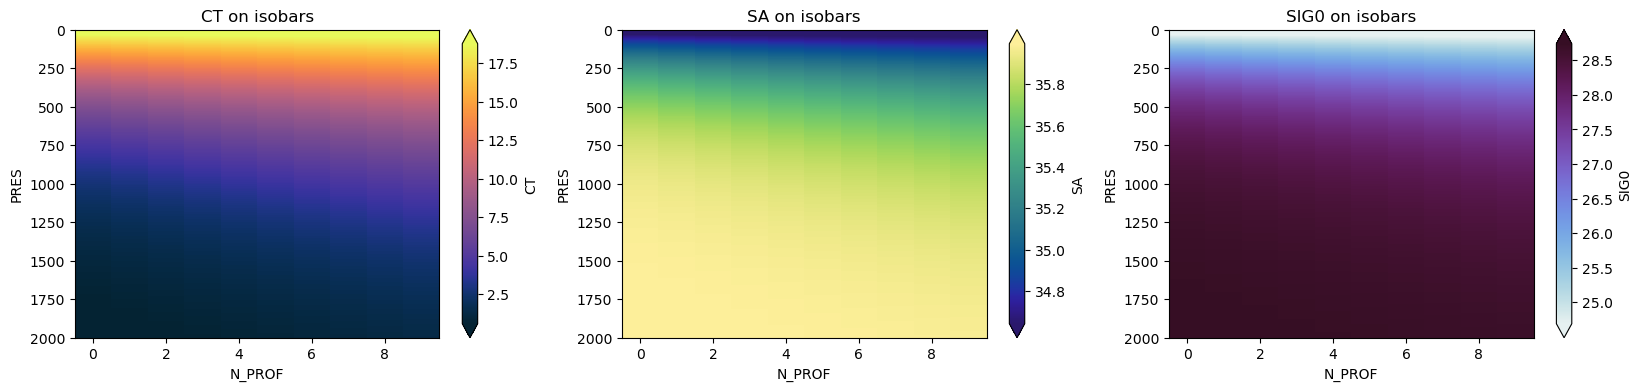

In [498]:
plt.figure(figsize=(20,4))

plt.subplot(131)
CT.plot(x='N_PROF', cmap=cmo.thermal, robust=True)
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(132)
SA.plot(x='N_PROF', cmap=cmo.haline, robust=True)
plt.gca().invert_yaxis()
plt.title('SA on isobars')

plt.subplot(133)
SIG0.plot(x='N_PROF', cmap=cmo.dense, robust=True)
plt.gca().invert_yaxis()
plt.title('SIG0 on isobars')

In [499]:
# Create a unified xarray Dataset
ds = xr.Dataset(
    {
        "CT": CT,
        "SA": SA,
        "SIG0": SIG0,
    }
)

In [500]:
ds

<xarray.Dataset> Size: 248kB
Dimensions:  (N_PROF: 10, PRES: 1001)
Coordinates:
  * N_PROF   (N_PROF) int64 80B 0 1 2 3 4 5 6 7 8 9
  * PRES     (PRES) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
Data variables:
    CT       (N_PROF, PRES) float64 80kB 20.0 19.92 19.84 ... 1.275 1.271 1.268
    SA       (N_PROF, PRES) float64 80kB 34.5 34.51 34.52 ... 35.98 35.98 35.98
    SIG0     (N_PROF, PRES) float64 80kB 24.26 24.29 24.32 ... 28.67 28.68 28.68

In [501]:
ds_rho = get_ds_rho(ds, ds.SIG0, np.arange(ds.SIG0.min(), ds.SIG0.max(), 0.0025), ['CT','SA','SIG0','PRES'])
ds_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['CT','SA','SIG0','PRES'], roll=25)

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for PRES
Completed PRES
Completed merge
Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for PRES
Completed PRES
Completed merge


Text(0.5, 1.0, 'CT on av isopycnal depth')

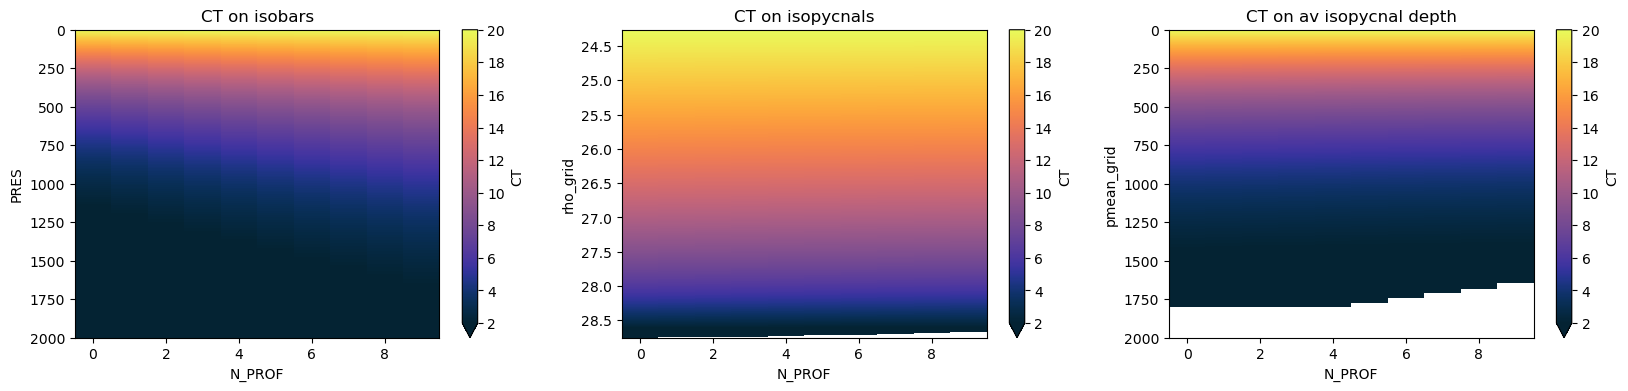

In [502]:
plt.figure(figsize=(20,4))

plt.subplot(131)
ds.CT.plot(x='N_PROF', cmap=cmo.thermal, vmin=2, vmax=20)
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(132)
ds_rho.CT.plot(x='N_PROF', cmap=cmo.thermal, vmin=2, vmax=20)
plt.gca().invert_yaxis()
plt.title('CT on isopycnals')

plt.subplot(133)
ds_pmean.CT.plot(x='N_PROF', cmap=cmo.thermal, vmin=2, vmax=20)
plt.gca().invert_yaxis()
plt.title('CT on av isopycnal depth')

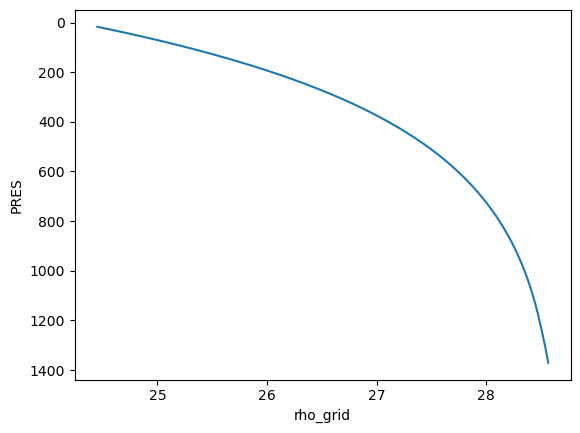

In [503]:
roll = 150
mean_smooth = ds_rho.PRES.mean('N_PROF').rolling(rho_grid=roll, center=True).mean().plot()
plt.gca().invert_yaxis()